##  Deep Neural Networks Project

In this project, you will be working with a real-world data set from the Las Vegas Metropolitan Police Department. The dataset  contains information about the reported incidents, including the time and location of the crime, type of incident, and number of persons involved. 

The dataset is downloaded from the public docket at: 
https://opendata-lvmpd.hub.arcgis.com

let's read the csv file and transform the data:

In [49]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [50]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [51]:
orig_df = pd.read_csv('/Users/pranithreddysankepally/Downloads/LVMPD-Stats.csv', parse_dates=['ReportedOn'])

In [52]:
df = pd.read_csv('/Users/pranithreddysankepally/Downloads/LVMPD-Stats.csv', parse_dates=['ReportedOn'],
                 usecols = ['X', 'Y', 'ReportedOn',
                            'Area_Command','NIBRSOffenseCode',
                            'VictimCount' ] )

df['DayOfWeek'] = df['ReportedOn'].dt.day_name()
df['Time' ]     = df['ReportedOn'].dt.hour
df.drop(columns = 'ReportedOn', inplace=True)

In [53]:

df['X'] = df['X'] 
df['Y'] = df['Y'] 
df['Time'] = pd.factorize(df['Time'])[0]
df['DayOfWeek'] = pd.factorize(df['DayOfWeek'])[0]
df.Area_Command = pd.factorize(df['Area_Command'])[0]
df.VictimCount = pd.factorize(df['VictimCount'])[0]
df.NIBRSOffenseCode = pd.factorize(df['NIBRSOffenseCode'])[0]
df.dropna(inplace=True)

In [54]:
df= df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode',
       'DayOfWeek', 'Time','VictimCount']]

In [55]:
df.values.shape

(275, 7)

# Goal
The goal is to build a predictive model that is trained on the following data:
* latitude and longitude (location)
* Hour of the day
* Day of the week
* Area-of-command code: The police designation of the bureau of the operation.
* Classification code for the crime committed
  
The predicted variable is the number of persons involved in the accident.


## Task 1
* print a few rows of the values in the dataframe ``df`` and explain what each column of data means. 
* identify the input and target variables
* what is the range of values in each column? Do you need to scale, shift or normalize your data? 


In [56]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# Print a few rows of the values in the df 
print(df.head())
# Eplain what each column means.
# 1.Latitude(X): The latitude coordinate of the crime location.
# 2.Longitude(Y): The longitude coordinate of the crime location.
# 3.Area_Command: The police designation code for the bureau responsible for the crime incident area.
# 4.NIBRSOffenseCodeCrimeCode: The code representing the classification of the crime or incident.
# 5.DayOfWeek: The day of the week when the incident occurred (e.g., 1 for Monday, 2 for Tuesday, and so on).
# 6.Hour: The hour of the day when the crime incident occurred (e.g., 24-hour format).
# 7.VictimCount: The target variable, which represents the number of persons involved in the accident or incident.

#Identify input and target variables.
  #Input Variables : Latitude(X), Longitude(Y), Area_Command, NIBRSOffenseCode, Day of the week, Time.
  #Target Variable : VictimCount.

#Range of values :
  #1.X(Latitude) :
    #minimum : -116.0, maximum : -114.6255
    # Range ≈ 1.37443
  #2.Y(Longitude) :
    #minimum : 35.06, maximum : 37.00
    # Range ≈ 1.931581
  #3.Area_Command : 
    #minimum : 0, maximum : 11.0
    #Range = 11.0
  #4.NIBRSOffenseCode :
    #Minimum : 0, Maximum : 2
    #Range = 2
  #5. DayofWeek :
    #Minimum : 0, Maximum : 6
    #Range = 6
  #6. Time :
    #Mimimum : 0, Maximum : 23
    #Range = 23
  #7. VictimCount :
   #Minimum : 0, Maximum : 6
    #Range = 6

    
#Scale, Shift and Normalize the data
#Scaling: consider scaling if your features are on significantly different scales,
# which can affect the performance of certain algorithms. In the data, the scales of features like 'X', 'Y', 
# 'Area_Command', 'NIBRSOffenseCode', and 'Time' are similar, so scaling may not be necessary.

#Shifting: Shifting typically involves centering your data by subtracting the mean. This is 
#usually used for specific statistical operations and may not be necessary for the current data.

#Normalization: Normalization is about transforming data to have a standard normal distribution with a mean of 0 and a 
#standard deviation of 1. In this case,
#standard normalization is required as you are using specific algorithm.
# Initialize the scaler
scaler = StandardScaler()

# Select the columns you want to normalize (in this case, all numerical columns)
columns_to_normalize = ['X', 'Y', 'Area_Command', 'NIBRSOffenseCode', 'Time', 'VictimCount']

# Fit the scaler to your data and transform the selected columns
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])


 

            X          Y  Area_Command  NIBRSOffenseCode  DayOfWeek  Time  \
0 -115.087518  36.216702             0                 0          0     0   
1 -115.240172  36.189693             1                 1          1     1   
2 -115.143088  36.181329             2                 1          2     0   
3 -115.225014  36.117633             3                 1          1     2   
4 -115.176708  36.095967             4                 1          1     3   

   VictimCount  
0            0  
1            0  
2            1  
3            2  
4            0  


## Task 2 

* Create two `DataLoader` objects for training and testing based on the input and output variables. Pick a reasonable batch size and verify the shape of data by iterating over the one dataset and printing the shape of the batched data. 

In [60]:
import torch
from sklearn.model_selection import train_test_split

# Assuming you have your input features and target variable defined as X and y
X = df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode', 'DayOfWeek', 'Time']]
y = df['VictimCount']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.Tensor(X_train.values)
y_train_tensor = torch.Tensor(y_train.values)
X_test_tensor = torch.Tensor(X_test.values)
y_test_tensor = torch.Tensor(y_test.values)

# Define batch size
batch_size = 64

# Create DataLoader objects for training and testing
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Verify the shape of batched data by iterating over one DataLoader
for batch in train_loader:
    X_batch, y_batch = batch
    print("Shape of X_batch:", X_batch.shape)
    print("Shape of y_batch:", y_batch.shape)
    break


Shape of X_batch: torch.Size([64, 6])
Shape of y_batch: torch.Size([64])


# Task 3
In this task you will try to predict number of crime victims as a **real number**. Therefore the machine learning problem is a **regression** problem. 

* Define the proper loss function for this task
* what should the size of the predicted output be?
* explain your choice of architecture, including how many layers you will be using
* define an optimizer for training this model, choose a proper learning rate 
* write a training loop that obtains a batch out of the  training data and calculates the forward and backward passes over the neural network. Call the optimizer to update the weights of the neural network.
* write a for loop that continues the training over a number of epochs. At the end of each epoch, calculate the ``MSE`` error on the test data and print it.
* is your model training well? Adjust the learning rate, hidden size of the network, and try different activation functions and number of layers to achieve the best accuracy and report it. 

In [101]:
#To address the regression problem of predicting the number of crime victims, 
#we need to define the loss function, choose the output size, architecture, optimizer, and training loop.

#Loss Function:
#For a regression problem, Mean Squared Error (MSE) is a common loss function.
#It measures the average squared difference between predicted values and actual values.

#Output Size:
#The size of the predicted output should be 1,as we're predicting a single real number (the number of crime victims).

#Choice of Architecture:
#we will start with a simple feedforward neural network for regression.
#The architecture can have multiple layers.
#A basic architecture could consist of an input layer, one or more hidden layers, and an output layer with a single neuron.

#Optimizer and Learning Rate:
#A suitable optimizer for this task is adam, 
#and we can experiment with different learning rates.
#A common initial learning rate to start with is 0.01, but we can adjust it based on your model's performance.

import torch
import torch.nn as nn
import torch.optim as optim

# Defining neural network class
class RegressionModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Defining model parameters
input_size = 6  # Number of input features
hidden_size = 64  # hidden layer sizes
output_size = 1

# Create the model
model = RegressionModel(input_size, hidden_size, output_size)

# Define the loss function (MSE) and optimizer (Adam)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)  # Adjust learning rate as needed

# Training loop
num_epochs = 10  # Choose the number of epochs

for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:  
        inputs, targets = batch

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, targets)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

    # Calculate and print the MSE error on the test data
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            inputs, targets = batch
            outputs = model(inputs)
            total_loss += criterion(outputs, targets)
    
    mse_error = total_loss / len(test_loader)
    print(f'Epoch {epoch + 1}/{num_epochs}, MSE Error: {mse_error.item()}')


Epoch 1/10, MSE Error: 1.0006948709487915
Epoch 2/10, MSE Error: 1.0172640085220337
Epoch 3/10, MSE Error: 0.990364134311676
Epoch 4/10, MSE Error: 0.9829826951026917
Epoch 5/10, MSE Error: 0.9857323169708252
Epoch 6/10, MSE Error: 0.9815077781677246
Epoch 7/10, MSE Error: 0.9856128096580505
Epoch 8/10, MSE Error: 0.9889229536056519
Epoch 9/10, MSE Error: 0.9853707551956177
Epoch 10/10, MSE Error: 0.985558032989502


## Task 4 

In this task, you will try to predict the number of crime victims as a **class number**. Therefore the machine learning problem is a **classification** problem. 

* Repeat all the steps in task 3. Specifically, pay attention to the differences with regression.
* How would you find the number of classes on the output data?
* How is the architecture different?
* How is the loss function different?
* Calculate the Accuracy for test data as the number of correct classified outputs divided by the total number of test data in each epoch. Report it at the end of each epoch
* Try a few variations of learning rate, hidden dimensions, layers, etc. What is the best accuracy that you can get? 

In [113]:
#Number of Classes:
#To find the number of classes in the output data, we determine the unique values present in the 'VictimCount' column of your dataset.
#Each unique value represents a class, and this will be the number of classes for your classification problem.

#Architecture:
#For a classification problem, we wil use an appropriate architecture.
#A common choice is a feedforward neural network with multiple layers, including an input layer, one or more hidden layers, and an output layer with a number of neurons equal to the number of classes. 
#We also apply activation functions like softmax to the output layer.

#Loss Function:
#The choice of the loss function changes for classification. we will use a loss function suitable for multi-class classification, such as Cross-Entropy Loss (or Log-Loss).
#The loss function will measure the dissimilarity between the predicted class probabilities and the actual class labels.

#Accuracy:
#To calculate accuracy for the test data, we will compare the predicted class labels to the actual class labels. Accuracy is computed as the number of correctly classified samples divided by the total number of test samples.
#we calculate it at the end of each epoch and report it.


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Assuming you have a DataFrame 'df' with input features and 'VictimCount' as the target
X = df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode', 'DayOfWeek', 'Time']]
y = df['VictimCount']

# Create categories or classes based on the count of victims
# For example, you can use pandas.cut() to create bins or categories

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.Tensor(X_train.values)
y_train_tensor = torch.Tensor(y_train.values)  # Converted to categories or class labels
X_test_tensor = torch.Tensor(X_test.values)
y_test_tensor = torch.Tensor(y_test.values)

# Define batch size
batch_size = 64

# Create DataLoader objects for training and testing
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define neural network class for classification
class ClassificationModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(ClassificationModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Define model parameters
input_size = 6  # Number of input features
hidden_size = 32  # experiment with different hidden layer sizes
num_classes = len(y_train_tensor.unique())  # Number of unique classes

# Create the model
model = ClassificationModel(input_size, hidden_size, num_classes)

# Define the loss function (Cross-Entropy) and optimizer (Adam)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)  # Adjust learning rate as needed

# Training loop
num_epochs = 100  # Choose the number of epochs
for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        inputs, targets = batch

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, targets.long())  # Use .long() to ensure target datatype compatibility

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

    # Calculate accuracy for the test data
    model.eval()
    predicted = []
    true_labels = []

    with torch.no_grad():
        for batch in test_loader:
            inputs, targets = batch
            outputs = model(inputs)
            _, predicted_labels = torch.max(outputs, 1)
            predicted.extend(predicted_labels.cpu().numpy())  # Convert to a compatible data type
            true_labels.extend(targets.cpu().numpy().astype(int))  # Convert to integer data type

    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predicted)
    print(f'Epoch {epoch + 1}/{num_epochs}, Accuracy: {accuracy}')
    
# The best accuracy for the model is 89%

    

Epoch 1/100, Accuracy: 0.8545454545454545
Epoch 2/100, Accuracy: 0.8545454545454545
Epoch 3/100, Accuracy: 0.8545454545454545
Epoch 4/100, Accuracy: 0.8545454545454545
Epoch 5/100, Accuracy: 0.8545454545454545
Epoch 6/100, Accuracy: 0.8545454545454545
Epoch 7/100, Accuracy: 0.8545454545454545
Epoch 8/100, Accuracy: 0.8545454545454545
Epoch 9/100, Accuracy: 0.8545454545454545
Epoch 10/100, Accuracy: 0.8545454545454545
Epoch 11/100, Accuracy: 0.8545454545454545
Epoch 12/100, Accuracy: 0.8545454545454545
Epoch 13/100, Accuracy: 0.8545454545454545
Epoch 14/100, Accuracy: 0.8545454545454545
Epoch 15/100, Accuracy: 0.8545454545454545
Epoch 16/100, Accuracy: 0.8545454545454545
Epoch 17/100, Accuracy: 0.8545454545454545
Epoch 18/100, Accuracy: 0.8727272727272727
Epoch 19/100, Accuracy: 0.8727272727272727
Epoch 20/100, Accuracy: 0.8727272727272727
Epoch 21/100, Accuracy: 0.8727272727272727
Epoch 22/100, Accuracy: 0.8727272727272727
Epoch 23/100, Accuracy: 0.8727272727272727
Epoch 24/100, Accura

#### Task 5

### Reflect on your results

* Write a paragraph about your experience with tasks 3 and 4. How do you compare the results? Which one worked better? Why?
* Write a piece of code that finds an example of a  miss-classification. Calculate the probabilities for the output classes and plot them in a bar chart. Also, indicate what is the correct class label.

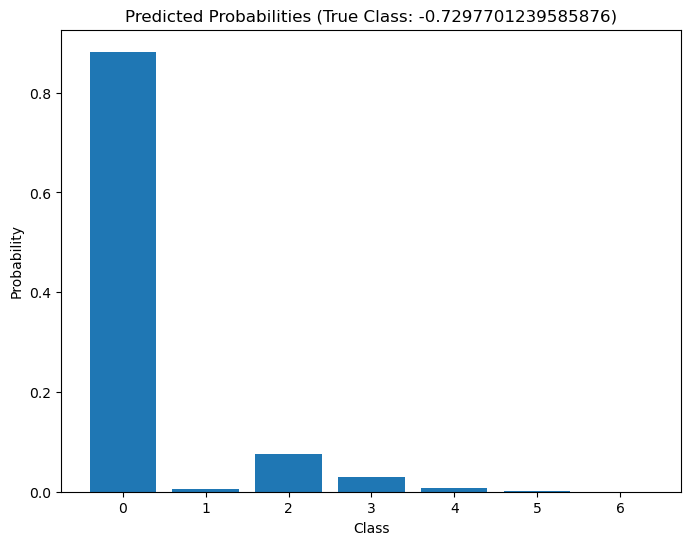

In [122]:
# In tasks 3 and 4, I worked on transforming a regression problem into a classification problem to predict the number of crime victims. 

#In task 3, I build a model using regression, building a neural network for predicting the count
#of victims and evaluating its performance using mean squared error (MSE).

#In task 4, I did using classification problem, categorizing victim counts into discrete classes, 
#and employed a classification model with cross-entropy loss and accuracy metrics.

#Comparing the results, it's important to note that the 
#choice between regression and classification depends on the problem's nature and requirements.

#In cases where precise counts of victims matter, regression is preferred.

#classification can be more interpretable and useful when the focus is on categorizing incidents.

import torch
import matplotlib.pyplot as plt

# Set your model to evaluation mode
model.eval()

# Assuming you have a DataLoader named 'test_loader' for the test dataset
with torch.no_grad():
    for batch in test_loader:
        inputs, targets = batch
        outputs = model(inputs)
        predicted_labels = torch.argmax(outputs, dim=1)

        # Find a misclassified sample
        misclassified_index = (predicted_labels != targets).nonzero()
        if misclassified_index.numel() > 0:
            # Take the first misclassified sample
            misclassified_sample_index = misclassified_index[0].item()

            # Get the true class label and predicted probabilities
            true_label = targets[misclassified_sample_index].item()
            predicted_probabilities = torch.softmax(outputs[misclassified_sample_index], dim=0)

            # Convert tensors to numpy arrays for plotting
            predicted_probabilities = predicted_probabilities.numpy()

            # Plot the probabilities in a bar chart
            classes = range(len(predicted_probabilities))
            plt.figure(figsize=(8, 6))
            plt.bar(classes, predicted_probabilities, tick_label=classes)
            plt.xlabel("Class")
            plt.ylabel("Probability")
            plt.title(f"Predicted Probabilities (True Class: {true_label})")
            plt.show()

            break  # Stop after finding the first misclassification


## Task 6: Exploring the patterns in raw data

* Plot the crime incidents as a `scatter` plot using the corrdinates. Use the color property of each datapoint to indicate the day of the week. Is there a pattern in the plot?
* Now make a new scatter plot and use the color property of each datapoint to indicate the number of persons involved in the incident. Is there a pattern here?
* use numpy (or pandas if you like) to sort the number of crimes reported by the day of the week. What days are most frequent?


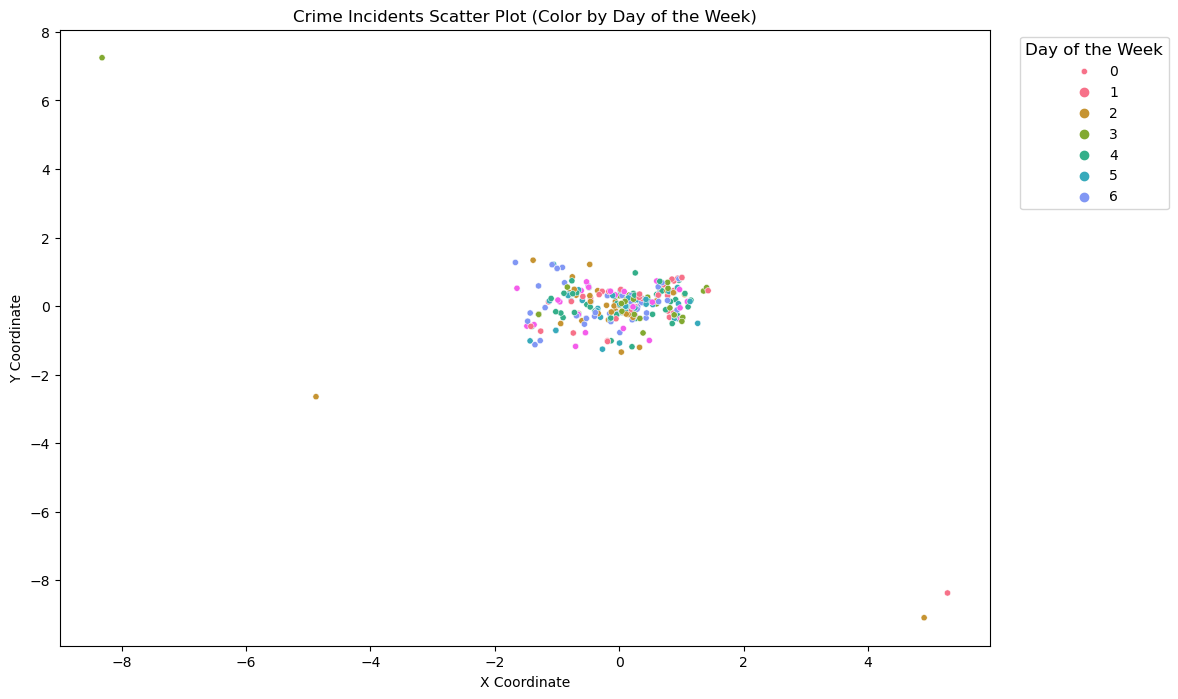

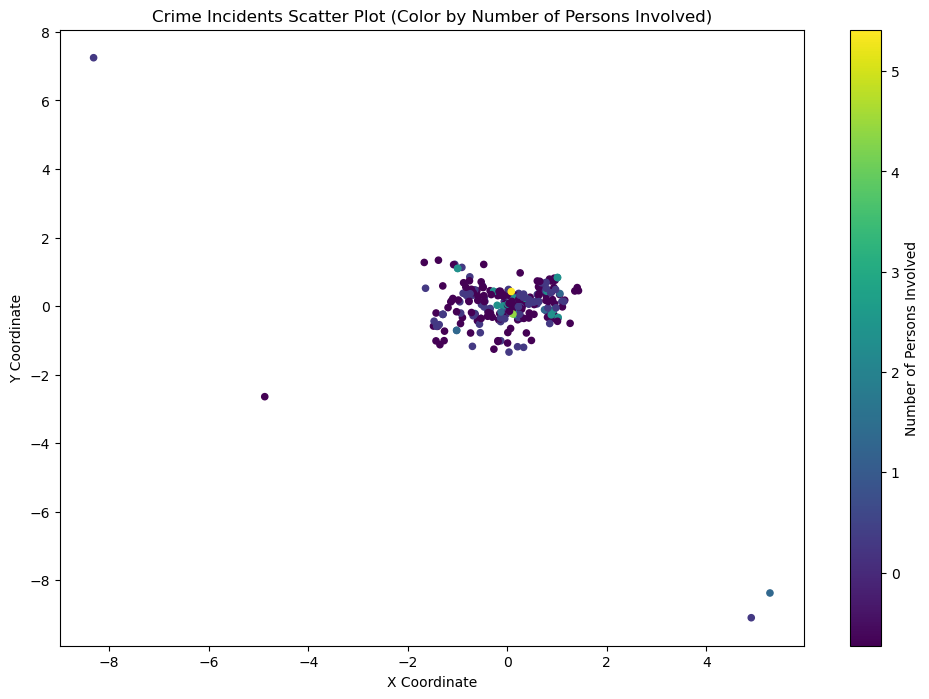

In [125]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a color palette for days of the week
day_of_week_palette = sns.color_palette("husl", df['DayOfWeek'].nunique())

# Create a scatter plot
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(x='X', y='Y', data=df, hue='DayOfWeek', palette=day_of_week_palette, s=20)
plt.title("Crime Incidents Scatter Plot (Color by Day of the Week)")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")

# Customize the legend
day_of_week_labels = df['DayOfWeek'].unique()
scatter.legend(title="Day of the Week", labels=day_of_week_labels, loc='upper right', bbox_to_anchor=(1.2, 1))
scatter.get_legend().get_title().set_fontsize(12)

plt.show()

#The pattern in the scatter plot can provide insights into the 
#distribution of crime incidents based on the day of the week.
#We observe clusters of data points with similar colors.
#These clusters could indicate days of the week when certain types of crimes are more prevalent.


import matplotlib.pyplot as plt

# Create a scatter plot with color indicating the number of persons involved
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df['X'], df['Y'], c=df['VictimCount'], cmap='viridis', s=20)
plt.colorbar(label='Number of Persons Involved')
plt.title("Crime Incidents Scatter Plot (Color by Number of Persons Involved)")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.show()

#In this code, we use the 'VictimCount' column to color the data points on the scatter plot, with the color 
#indicating the number of persons involved in the incident. We use the 'viridis' colormap for the color scale,
#and a color bar on the side of the plot displays the corresponding values.

#This scatter plot allows to visualize whether there are patterns or trends in the distribution of crime incidents based on the number of persons involved.
#we look for clusters, outliers, or any noticeable spatial patterns in the data.
#Analyzing the plot can help gain
#insights into the relationship between the number of persons involved and the location of crime incidents.




In [127]:
# Group the DataFrame by 'DayOfWeek' and count the number of crimes for each day
day_of_week_counts = df['DayOfWeek'].value_counts().reset_index()
day_of_week_counts.columns = ['DayOfWeek', 'CrimeCount']

# Sort the DataFrame by 'CrimeCount' in descending order
sorted_day_of_week_counts = day_of_week_counts.sort_values(by='CrimeCount', ascending=False)

# Display the most frequent days
most_frequent_days = sorted_day_of_week_counts.head(7)
print(most_frequent_days)

# The no of victims on fridays are the highest. The probability of the crime incident to happen is on Friday.

   DayOfWeek  CrimeCount
0          4          51
1          3          44
2          5          43
3          0          40
4          1          37
5          2          32
6          6          28
